Use MobileNetV2 from TensorFlow Hub as a fixed feature extractor and train a custom classifier on a small dataset (e.g. cats vs dogs)

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout

In [2]:
#Load cat vs dog dataset

(train_ds, val_ds), ds_info = tfds.load(
    'oxford_iiit_pet',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

IMG_SIZE = 224

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess(image, label):
    IMG_SIZE = 224
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0

    # Labels: 1 = Dog, 0 = Cat
    label = tf.cast(label >= 10, tf.int32)  # convert 0-36 breed label to 0 (cat) or 1 (dog)
    return image, label

train_ds = train_ds.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [3]:
#Load MobileNetV2 as feature extractor (Frozen)
feature_extractor_url="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [4]:
model=Sequential([
    data_augmentation,
    hub.KerasLayer(feature_extractor_url,input_shape=(224, 224,3),trainable=False),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [5]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [6]:
model.fit(train_ds,validation_data=val_ds,epochs=3)

Epoch 1/3
92/92 [==============================] - 90s 922ms/step - loss: 0.3461 - accuracy: 0.8475 - val_loss: 0.2518 - val_accuracy: 0.8995
Epoch 2/3
92/92 [==============================] - 96s 1s/step - loss: 0.2307 - accuracy: 0.9029 - val_loss: 0.2636 - val_accuracy: 0.8804
Epoch 3/3
92/92 [==============================] - 113s 1s/step - loss: 0.1982 - accuracy: 0.9192 - val_loss: 0.2223 - val_accuracy: 0.9103


In [7]:
loss,accuracy=model.evaluate(val_ds)
print(f"Loss: {loss:.2f}, Accuracy: {accuracy:.2f}")

23/23 [==============================] - 20s 855ms/step - loss: 0.2223 - accuracy: 0.9103
Loss: 0.22, Accuracy: 0.91


1/1 [==============================] - 3s 3s/step


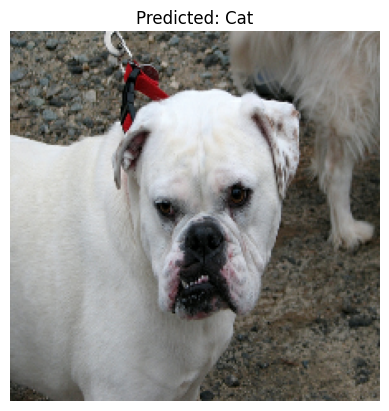

1/1 [==============================] - 0s 230ms/step


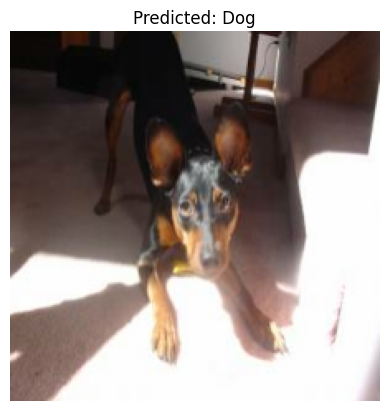

1/1 [==============================] - 0s 235ms/step


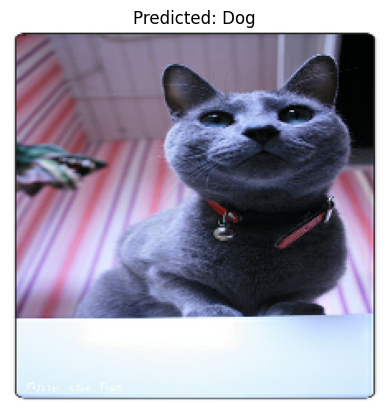

In [8]:
for image, label in val_ds.take(3):
    pred = model.predict(image[:3])
    plt.imshow(image[0])
    plt.title(f"Predicted: {'Dog' if pred[0][0] > 0.5 else 'Cat'}")
    plt.axis('off')
    plt.show()
   
